# Проект: Статистический анализ данных.

Я аналитик популярного сервиса аренды самокатов GoFast. Заказчик мне передал данные о некоторых пользователях из нескольких городов, а также об их поездках и подписках. Мне стало известно что пользователи сервиса GoFast используют одноименное мобильное приложение.
Сервисом можно пользоваться:
* **без подписки**, при этом абонентская плата отсутствует, стоимость одной минуты поездки — 8 рублей, стоимость старта (начало поездки) — 50 рублей;
* и **с подпиской Ultra**, при этом абонентская плата — 199 рублей в месяц, стоимость одной минуты поездки — 6 рублей, стоимость старта — бесплатно.

<b>Цель исследования: </b>Проанализировать данные, подсчитать помесячную выручку с пользователя и общую годовую выручку сервиса GoFast, а также проверить некоторые гипотезы, которые помогут бизнесу заказчика вырасти.

<b>Ход исследования: </b>Данные о сервисе проката самокатов GoFast я получил от заказчика исследования в трёх файлах: '/datasets/users_go.csv', '/datasets/rides_go.csv' и '/datasets/subscriptions_go.csv'. О качестве данных ничего не известно. Перед началом исследования необходимо провести загрузку и обзор данных. Далее буду проверять данные на ошибки и оценивать возможное влияние на результаты исследования. Затем проведу предобработку данных чтобы минимизировать искажение результатов, преобразую некоторые данные, создам новые столбцы, переименую некоторые переменные и приступлю к проведению исследовательского анализа.

Моё исследование будет проходить в несколько этапов: 
    
1.  Обзор данных.
2.  Предобработка данных.
3.  Исследовательский анализ данных.
4.  Объединение данных.
5.  Подсчёт выручки.
6.  Проверка гипотез.
7.  Распределения.
8.  Оформление итогового вывода исследования.

---

## Обзор данных

Импортирую библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom
pd.set_option('display.max_rows', None)

### С помощью pandas открываю данные, создаю таблицы и вывожу на экран первые строки.

In [2]:
df_rides = pd.read_csv('/datasets/rides_go.csv')
df_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [3]:
df_users = pd.read_csv('/datasets/users_go.csv')
df_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
df_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
df_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


### Изучаю общую информацию о данных в таблицах.

In [5]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
df_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [8]:
df_rides.duplicated().sum()

0

In [9]:
df_users.duplicated().sum()

31

In [10]:
df_subscriptions.duplicated().sum()

0

Вывод: В таблице df_rides:  18068 строк, 4 столбца. Пропуски отсутствуют. В двух столбцах необходимо изменить тип данных. 
В таблице df_users:   1565 строк и 4 столбца. Пропуски данных отсутствуют. В ней же обнаружен 31 дубликат: дубликаты необходимо будет удалить.
В таблице df_subscriptions 2 строки и 4 столбца. Пропуски и дупликаты отсутствуют.
Считаю что данные полные и корректные для проведения заданного исследования.

## Предобработка данных

### Удаляю дубликаты в таблице df_users.

In [11]:
df_users = df_users.drop_duplicates(subset='user_id', keep='first')
df_users['user_id'].duplicated().sum()

0

### Преобразую тип данных столбца 'date' таблицы df_rides из 'object' в 'datetime', затем сам столбец преобразую в 'month'(месяц).

In [12]:
df_rides['date'] = pd.to_datetime(df_rides['date'], format=('%Y-%m-%d'))
df_rides['month'] = df_rides['date'].dt.month
df_rides['month'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Проверяю какой период охватывают данные:

In [13]:
df_rides['date'].describe()

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

Вывод: Данные для исследования охватывают период с 01-01-2021 по 29-12-2021.

### Округляю значения расстояния 'distance' таблицы df_rides до сотых метра.

In [14]:
df_rides['distance'] = df_rides['distance'].round(2)

В соответствии с пунктом 5.2 исследовательского задания продолжительность каждой поездки округляю с помощью метода «потолок» библиотеки numpy — np.ceil(). Затем изменяю тип данных с 'float' на 'int'.

In [15]:
df_rides['duration'] = np.ceil(df_rides['duration'])
df_rides['duration'] = df_rides['duration'].astype('int')
df_rides.sample(6)

,user_id,distance,duration,date,month
14183,1257,2315.22,9,2021-07-12,7
3109,335,3787.96,19,2021-04-01,4
12729,1156,4292.20,18,2021-02-26,2
6533,701,4139.74,17,2021-09-25,9
1986,215,2514.91,15,2021-04-26,4
10712,1008,3402.62,10,2021-01-23,1


Вывод: В процессе предобработки данных: обнаруженные дубликаты в таблице df_users были удалены. В таблице df_rides значения расстояния 'distance' были округлены до сотых метра, а значения продолжительности поездки 'duration', были округлены вверх и их тип данных был изменён с 'float' на 'int'. Данные столбца 'date' были приведены к формату даты datetime. Затем столбец 'date' был преобазован в 'month'. В таблице df_subcriptions данные не изменились.

## Исследовательский анализ данных  службы GoFast

### Изучу частоту встречаемости городов в данных.

In [16]:
cities = df_users.pivot_table(index='city', values='user_id', aggfunc='count')
cities.columns = ['users_quantity']
cities.sort_values(by='users_quantity', ascending=True)

,users_quantity
city,
Москва,168
Тюмень,180
Омск,183
Сочи,189
Краснодар,193
Ростов-на-Дону,198
Екатеринбург,204
Пятигорск,219


Text(0, 0.5, 'Количество пользователей')

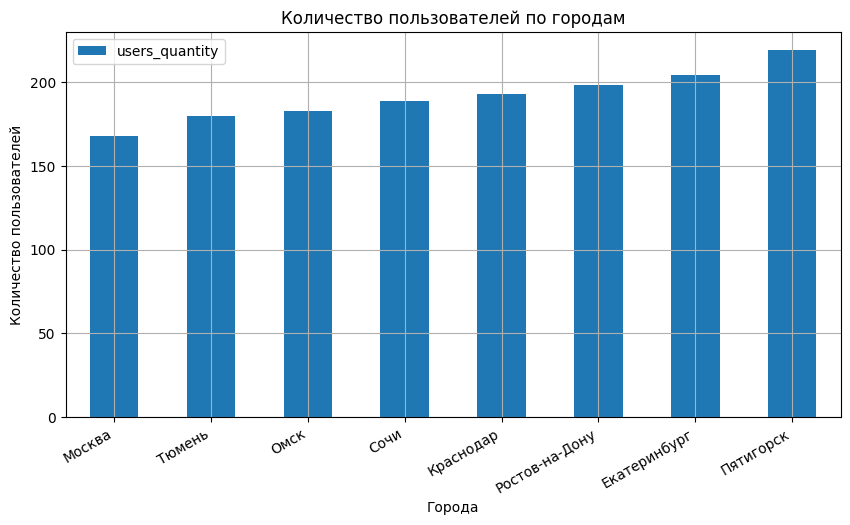

In [17]:
cities.sort_values(by='users_quantity', ascending=True) \
.plot(kind="bar", grid=True, figsize=(10, 5), stacked = False)

plt.xticks(rotation=30, horizontalalignment="right")
plt.title("Количество пользователей по городам")
plt.xlabel("Города")
plt.ylabel("Количество пользователей")

Вывод: Сводная таблица и построенная на её основе визуализация показывают, что город-лидер по количеству пользователей: Пятигорск, что вполне обяснимо с учётом южного длинного курортного сезона. За лидером следуют Екатеринбург(несмотря на более северное расположение), и Ростов-на-Дону.

### Изучу соотношение количества пользователей с подпиской и без подписки.

In [18]:
df_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')

,user_id
subscription_type,
free,835
ultra,699


<Axes: title={'center': 'Диаграмма распределения подписки'}>

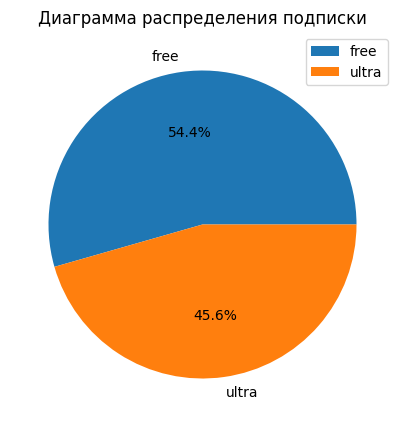

In [19]:
(df_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')) \
.plot.pie(y='user_id', figsize=(5, 5), label='', autopct='%1.1f%%', title='Диаграмма \
распределения подписки')

Вывод: Количество пользователей без подписки 54,4% превышает количество пользователей с подпиской 'ultra' 45,6%. Можно отметить что 45% постоянных клиентов - очень солидное достижение сервиса GoFast.

### Изучаю информацию о возрасте пользователей.

In [20]:
df_users.pivot_table(index='age', values='user_id', aggfunc='count')

,user_id
age,
12,4
13,8
14,9
15,13
16,19
17,26
18,46
19,47
20,71


In [21]:
df_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Text(0, 0.5, 'Количество пользователей')

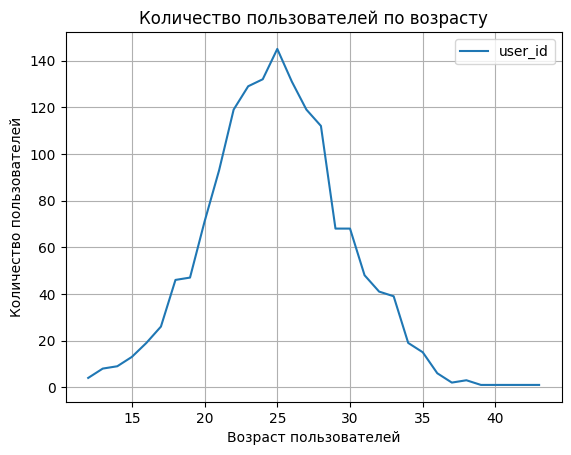

In [22]:
df_users.pivot_table(index='age', values='user_id', aggfunc='count').plot(grid='True')

plt.xticks()
plt.title("Количество пользователей по возрасту")
plt.xlabel("Возраст пользователей")
plt.ylabel("Количество пользователей")

Подкрепляю наблюдения с помощью boxplot().

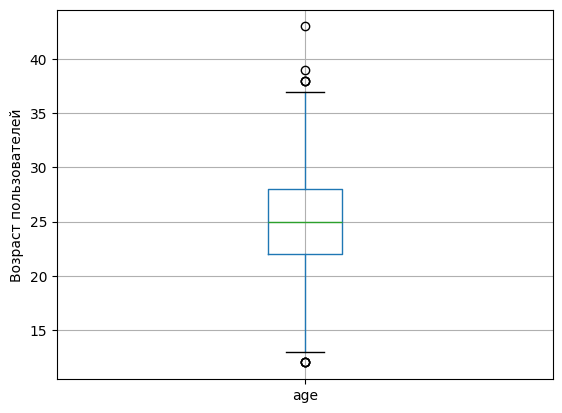

In [23]:
boxplot = df_users.boxplot(column=['age'])
plt.ylabel('Возраст пользователей')
plt.show()

Вывод: Средний возраст пользователя службы аренды самокатов соизмерим с медианным значением возраста: 25 лет. Распределение возраста нормальное с межквартильным интервалом от 22 до 28 лет, и с минимумом 15 лет и максимумом 35 лет.

### Изучаю расстояние, которое пользователь преодолел за одну поездку.

In [24]:
df_rides['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

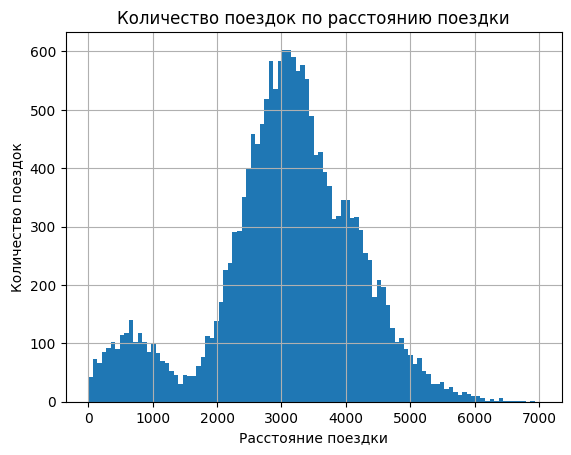

In [25]:
plt.hist(df_rides['distance'], bins=100, range=(0, 7000))
plt.title('Количество поездок по расстоянию поездки')
plt.xlabel('Расстояние поездки')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

Подкрепляю наблюдения с помощью boxplot().

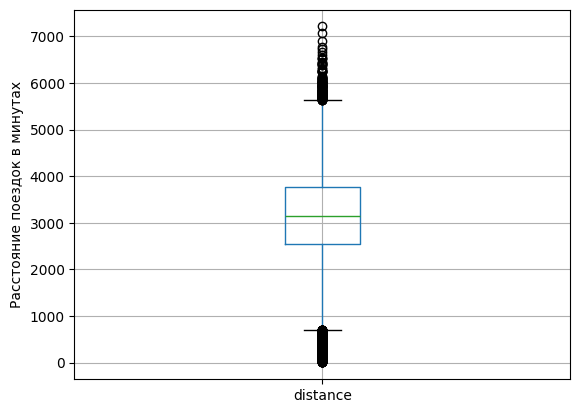

In [26]:
boxplot = df_rides.boxplot(column=['distance'])
plt.ylabel('Расстояние поездок в минутах')
plt.show()

Вывод: Самое большое количество поездок совершено на расстояния между первым квартилем: 2543 метров(Q1) и третьим квартильем: 3776 метров(Q3). Среднее и медианное значения расстояния практически соизмеримы 3133 и 3070 метров. На графике наблюдается нормальное распределение значения с двумя пиками: малый пик значения количества коротких поездок(расстояние около 700 метров) и пик значения количества всех поездок(расстояние около 3100 метров).

### Изучаю продолжительность поездок.

In [27]:
df_rides['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

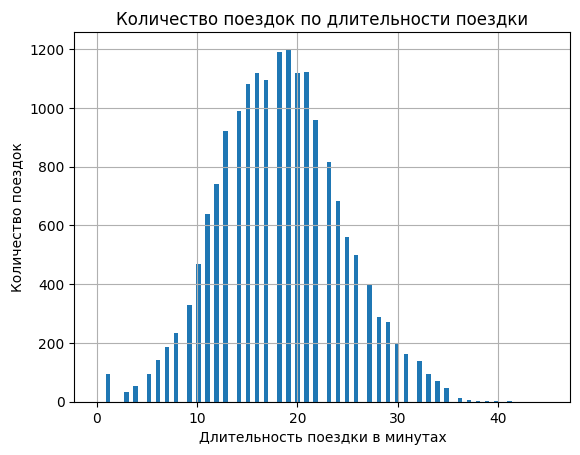

In [28]:
plt.hist(df_rides['duration'], bins=100, range=(0, 45))
plt.title('Количество поездок по длительности поездки')
plt.xlabel('Длительность поездки в минутах')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

Вывод: Визуализация количества поездок в зависимости от длительности поездки, показывает что среднее и медианное значения практически совпадают на значении 18 минут. Именно столько длится средняя поездка. Большинство поездок имеют продолжительность между 14 и 22 минут. Максимально длинные поездки длятся около 40 минут. Необходимо обратить внимание на около сотни поездок которые длились меньше одной минуты. 

Проверяю столбец длительность поездок на предмет наличия аномалий.

In [29]:
df_rides['duration'].sort_values(ascending=True).unique()

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41])

Подкрепляю наблюдения с помощью boxplot().

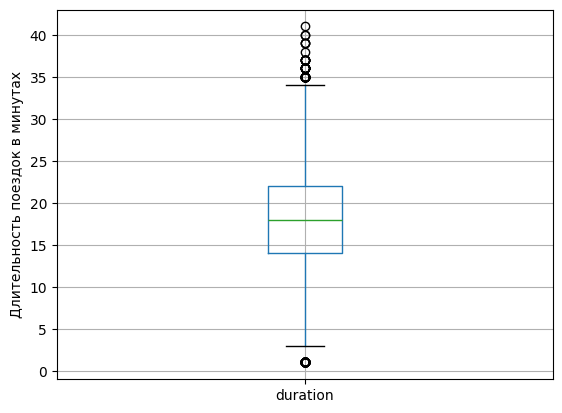

In [30]:
boxplot = df_rides.boxplot(column=['duration'])
plt.ylabel('Длительность поездок в минутах')
plt.show()

Вывод по аномальным значениям 'duration': Значения длительности поездки меньше трёх минут и больше 34 минут можно признать выбросами. Но удалить эти выбросы скорее всего, невозможно: дело в том, что 'duration' является тарифообразующей величиной в расчётах службы GoFast с пользователями и вполне возможно что за даже очень короткие поездки была взята оплата и выписаны кассовые чеки.

Вывод по исследовательскому анализу данных службы GoFast: 

1. Город-лидер по количеству пользователей: Пятигорск, что вполне обяснимо с учётом южного длинного курортного сезона. За лидером следуют Екатеринбург и Ростов-на-Дону.
2. Количество пользователей без подписки 54,4% превышает количество пользователей с подпиской 'ultra' 45,6%.
3. Средний возраст пользователя службы аренды самокатов соизмерим с медианным значением возраста: 25 лет. Распределение возраста нормальное с минимумом 12 лет и максимумом 43 года.
4. Самое большое количество поездок совершено на расстояния между первым квартилем: 2543 метров(Q1) и третьим квартильем: 3776 метров(Q3). Среднее и медианное значения расстояния практически соизмеримы 3133 и 3070 метров. На графике наблюдается нормальное распределение значения с двумя пиками: малый пик значения количества коротких поездок(расстояние около 700 метров) и пик значения количества всех поездок(расстояние около 3100 метров).
5. Среднее и медианное значения количества поездок в зависимости от длительности поездки, практически совпадают на значении 18 минут. Именно столько длится средняя поездка. Большинство поездок имеют продолжительность между 14 и 22 минут. Максимально длинные поездки длятся около 40 минут. Необходимо обратить внимание на около сотни поездок с аномальной длительностью меньше одной минуты. 

## Объединение данных

### С помощью метода merge() объединяю данные о пользователях, поездках и подписках в одну таблицу.

In [31]:
df_users_rides = df_users.merge(df_rides)
df_go_fast = df_users_rides.merge(df_subscriptions)
df_go_fast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  int32         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(5), object(3)
memory usage: 1.5+ MB


Проверяю размерность результирующей таблицы.

In [32]:
# длина исходных таблиц
print(f'Длина исходной таблицы с информацией о поездках df_rides: {len(df_rides)}')
print(f'Длина исходной таблицы с информацией о пользователях: {len(df_users)}')
print(f'Длина исходной таблицы с информацией о подписках: {len(df_subscriptions)}')

# длина результирующего датафрейма
print(f'Длина результирующего датафрейма: {len(df_go_fast)}')

Длина исходной таблицы с информацией о поездках df_rides: 18068
Длина исходной таблицы с информацией о пользователях: 1534
Длина исходной таблицы с информацией о подписках: 2
Длина результирующего датафрейма: 18068


In [33]:
if len(df_go_fast) == len(df_rides):
    print('Объединение таблиц методом merge() успешно прошло.')

Объединение таблиц методом merge() успешно прошло.


Вывод: Созданная таблица df_go_fast, объединяющая исходные таблицы df_rides, df_users и df_subscriptions, содержит 18068 строк во всех столбцах, что соответствует исходной таблице df_rides и указывает на отсутствие пропусков в столбцах. Объединение прошло успешно.


In [34]:
df_go_fast.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27,2021-08-28,8,6,0,199


### Создаю ещё две таблицы с таблицы, созданной на пункте 4.1:

первую таблицу c данными о пользователях с подпиской 'ultra':

In [35]:
go_fast_ultra = df_go_fast[df_go_fast['subscription_type'] == 'ultra']
go_fast_ultra.head() 

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27,2021-08-28,8,6,0,199


и вторую таблицу с данными о пользователях без подписки.

In [36]:
go_fast_free = df_go_fast[df_go_fast['subscription_type'] == 'free']
go_fast_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,15,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,17,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,21,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,10,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,18,2021-02-14,2,8,50,0


### Визуализирую информацию о расстоянии поездок для пользователей обеих категорий подписки с помощью совмещённой гистограммы.

In [37]:
go_fast_ultra['distance'].describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

In [38]:
go_fast_free['distance'].describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

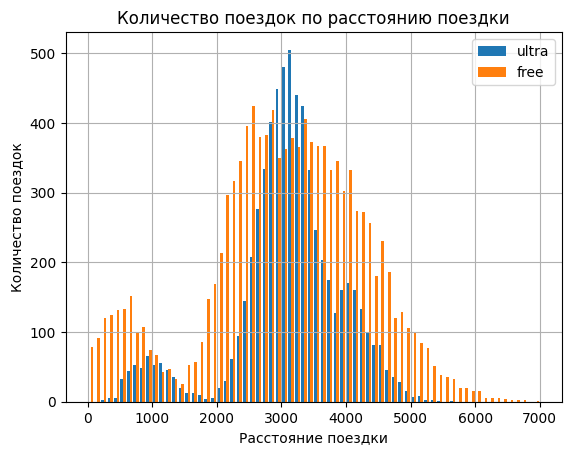

In [39]:
plt.hist([go_fast_ultra['distance'], go_fast_free['distance']], bins=70, range=(0, 7000), label=['ultra', 'free'])
plt.legend(loc='upper right')
plt.title('Количество поездок по расстоянию поездки')
plt.xlabel('Расстояние поездки')
plt.ylabel('Количество поездок')
plt.grid(True)

plt.show()

Вывод: Сравнение информации о поездках пользователей с подпиской и без подписки, плюс визуализация этой информации позволяет мне сделать вывод: Стандартное отклонение расстояния поездки 'distance' существенно, аж на 48,9% отличается в пользу "свободных пользователей", что говорит о системном характере поездок подписчиков 'ultra', скорее всего по одным и тем же маршрутам, и о непредсказуемости маршрутов поездок "свободных" пользователей: у них намного больше коротких, до 1 км, поездок и некоторое количество поездок больше пяти километров.

#### Визуализирую информацию о длительности поездок для пользователей обеих категорий подписки с помощью совмещённой гистограммы

In [40]:
go_fast_ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

In [41]:
go_fast_free['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

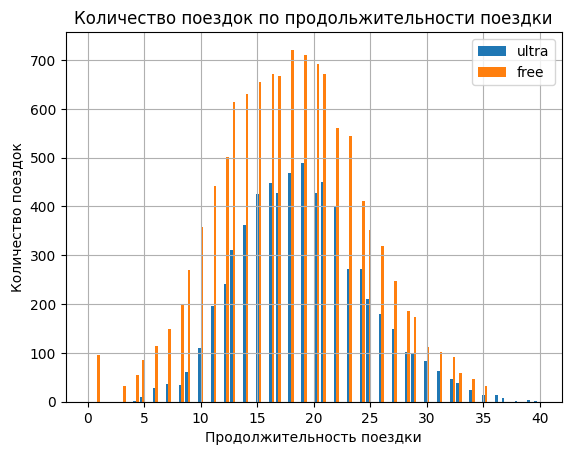

In [42]:
plt.hist([go_fast_ultra['duration'], go_fast_free['duration']], bins=70, range=(0, 40), label=['ultra', 'free'])
plt.legend(loc='upper right')
plt.title('Количество поездок по продольжительности поездки')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.grid(True)

plt.show()

Вывод: Стандартное отклонение значений длительности поездки 'duration' существенно, на 13,5% отличается в пользу "свободных пользователей", что говорит о системном характере поездок подписчиков 'ultra', скорее всего по одным и тем же маршрутам, и о непредсказуемости маршрутов поездок "свободных" пользователей. Пользователи без подписки чаще завершают поездку едва начав её, возможно что у них настроение быстро меняется, либо не понравился самокат, либо возникли проблемы с оплатой. У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей.

## Подсчёт выручки

Перед подсчётом выручки проверяю сводную таблицу df_go_fast на отсутствие пропусков.


In [43]:
df_go_fast.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Вывод: В сводной таблице для подсчёта выручки df_go_fast отсутствуют пропуски данных.

### Добавляю столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обращаюсь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Одновременно реорганизую и переименую сводную таблицу, сделаю  более говорящими названия таблицы и столбцов.

In [44]:
go_fast_revenue = df_go_fast.pivot_table(index=('user_id', 'month'), values=[
                'distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee']\
                , aggfunc={'distance': {'count', 'sum'}, 'duration': 'sum', 'minute_price': 'mean'\
                , 'start_ride_price': 'mean', 'subscription_fee': 'mean'})
go_fast_revenue.columns = ['month_rides', 'month_distance', 'month_duration', 'minute_price', 'start_ride_price', 'subscription_fee']

### Помесячная выручка с каждого пользователя считается по формуле: (стоимость старта поездки × количество поездок) + (стоимость одной минуты поездки × общая продолжительность всех поездок в минутах) + стоимость подписки.

In [45]:
go_fast_revenue['month_revenue_per_user'] = go_fast_revenue['start_ride_price'] * go_fast_revenue['month_rides'] \
+ go_fast_revenue['month_duration'] * go_fast_revenue['minute_price'] + go_fast_revenue['subscription_fee']
go_fast_revenue.head(8)

month_rides  month_distance  month_duration  minute_price  \
user_id month                                                              
1       1                2         7027.51              42           6.0   
        4                1          754.16               7           6.0   
        8                2         6723.47              46           6.0   
        10               2         5809.91              32           6.0   
        11               3         7003.50              56           6.0   
        12               2         6751.63              28           6.0   
2       3                3        10187.73              63           6.0   
        4                2         6164.39              40           6.0   

               start_ride_price  subscription_fee  month_revenue_per_user  
user_id month                                                              
1       1                   0.0             199.0                   451.0  
        4                   0.0             199.0                   241.0  
        8                   0.0             199.0                   475.0  
        10                  0.0             199.0                   391.0  
        11                  0.0             199.0                   535.0  
        12                  0.0             199.0                   367.0  
2       3                   0.0             199.0                   577.0  
        4                   0.0             199.0                   439.0

### Вычисляю годовую выручку службы с каждого пользователя.

In [46]:
year_revenue_per_user = go_fast_revenue.pivot_table(index=('user_id'), values='month_revenue_per_user', aggfunc='sum')
year_revenue_per_user = year_revenue_per_user.rename(columns={'month_revenue_per_user': 'year_revenue_per_user'})

### Вычисляю годовую выручку службы проката самокатов GoFast.

In [47]:
go_fast_year_revenue = year_revenue_per_user['year_revenue_per_user'].sum()
print(f'Выручка службы проката самокатов GoFast в 2021 году составила {go_fast_year_revenue} рублей.')

Выручка службы проката самокатов GoFast в 2021 году составила 3878641.0 рублей.


## Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверяю гипотезу. Использую исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

H0: Средняя продолжительность поездок с подпиской 'ultra' и без подписки равна.

H1: Средняя продолжительность поездок с подпиской 'ultra' больше средней продолжительности поездок без подписки.

In [48]:
results = st.ttest_ind(go_fast_ultra['duration'], go_fast_free['duration'], equal_var=True, alternative='greater')
print(results.pvalue)

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаю нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

2.495945372073663e-34
Отвергаю нулевую гипотезу


Вывод: Отвергаю нулевую гипотезу: средняя продолжительность поездок с подпиской 'ultra' больше средней продолжительности поездок без подписки.

### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

H0: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно оптимальному: 3130 метров.

H1: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку более 3130 метров.

In [49]:
distance = 3130
alpha = 0.05

results = st.ttest_1samp(go_fast_ultra['distance'], distance, alternative='greater')
print(results.pvalue)


if results.pvalue < alpha:
    print('Отвергаю нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


Вывод:Не удалось отвергнуть нулевую гипотезу: При установленном уровне статистической значимости, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не отличается от оптимального в 3130 метров.

### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

H0: Помесячная выручка от пользователей с подпиской равна помесячной выручке от пользователей без подписки.

H1: Помесячная выручка от пользователей с подпиской больше, чем помесячная выручка от пользователей без подписки.

Вычисляю помесячную выручку от пользователя с подпиской 'ultra'.

In [50]:
revenue_ultra = go_fast_revenue.loc[go_fast_revenue['subscription_fee'] == 199, 'month_revenue_per_user']

Вычисляю помесячную выручку от пользователя без подписки.

In [51]:
revenue_free = go_fast_revenue.loc[go_fast_revenue['subscription_fee'] == 0, 'month_revenue_per_user']

In [52]:
results = st.ttest_ind(revenue_ultra, revenue_free, equal_var=True, alternative='greater')
print(results.pvalue)

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаю нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаю нулевую гипотезу


Вывод: Нулевая гипотеза отвергнута: Помесячная выручка от пользователя с подпиской больше, чем помесячная выручка от пользователя без подписки.

### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Когда требуется проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок обычно применяют метод scipy.stats.ttest_rel(). В этом случае выборки считаются парными или зависимыми. Это означает, что некоторая переменная измеряется дважды для одних и тех же объектов. В данном примере это пара значений для каждого пользователя — до и после обновления серверов. Этому методу достаточно передать всего два параметра: набор данных для каждого пользователя до и после обновления серверов. Необходимо чтобы оба набора были одинаковыми по размеру: одно измерение проведено до и второе измерение сделано после обновления серверов. Порядок объектов в файле тоже должен быть одинаковый: до и после.
Если эти требования не выполняются, тогда использую метод scipy.stats.ttest_ind() для двух независимых выборок.

## Распределения

### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. Сколько промокодов необходимо раздать чтобы получить заданный результат? Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Решение этой задачи разделю на два этапа. Первый этап: математический.

In [53]:
n = 1000
k = 100
p = 0.1
binom_cdf = 0.05


for n in range(1000, 2000):
    if binom_cdf < binom.cdf(k, n, p):
        n += 1
        if binom_cdf == binom.cdf(k, n, p).round(2):
            print(n)
            break

1167


Вывод: 1167 штук - минимальное количество промокодов, которое нужно раздать среди пользователей, чтобы как минимум 100 существующих клиентов продлили месячную подписку и вероятность не выполнить план стала равной примерно 5 %.

Второй этап: графический, должен потвердить правильность результата первого этапа.

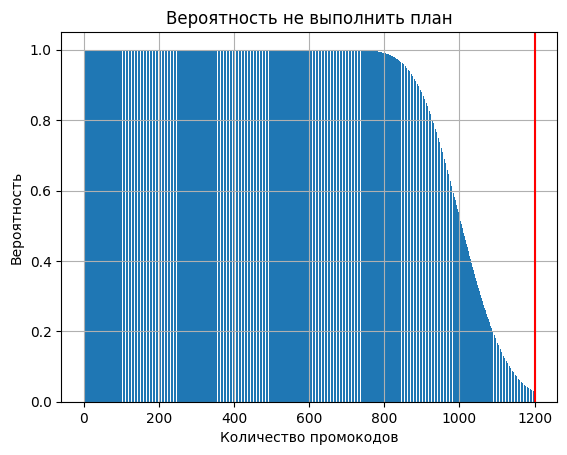

In [54]:
n = 1200 # количество попыток
p = 0.1 # вероятность успеха
k = 100
distr = []

for n in range(0, n + 1):
    current_value = binom.cdf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)
plt.title('Вероятность не выполнить план')
plt.axvline(x=n, color='red')
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность')
plt.grid(True)
plt.show()

Вывод: Визуализация потверждает что при значении количества разданных промокодов равном 1167, вероятность не выполнить план снижается до 5 %.

### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность равна: 15.37 %


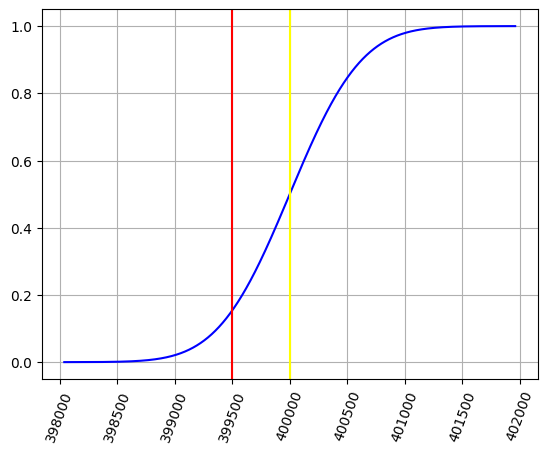

In [55]:
n = 1000000
p = 0.4
k = 399500

mu = n * p

sigma = (n * p * (1 - p))**0.5

distr = st.norm(mu, sigma)

result = distr.cdf(k)
print('Вероятность равна:',(result * 100).round(2), '%')

arange = np.arange((mu - 4 * sigma), (mu + 4 * sigma), 1)
plt.plot(arange, st.norm.cdf(arange, mu, sigma), 'b-')
plt.xticks(rotation=70)
plt.axvline(x=k, color='red')
plt.axvline(x=mu, color='yellow')
plt.grid(True)
plt.show()

Вывод: Если отдел маркетинга сможет отправить миллион push-уведомлений, тогда вероятность того, что не более 399500 получателей откроют это уведомление, будет равна 0,1537 или 15,37 %.

## Общий вывод по проекту: 

В ходе проведения Статистического исследования службы проката самокатов GoFast, были пройдены следующие этапы и сделаны следующие выводы:

1. Загрузка данных: В таблице df_rides: 18068 строк, 4 столбца. Пропуски отсутствуют. В двух столбцах необходимо изменить тип данных. В таблице df_users: 1565 строк и 4 столбца. Пропуски данных отсутствуют. В ней же обнаружен 31 дубликат: дубликаты необходимо будет удалить. В таблице df_subscriptions 2 строки и 4 столбца. Пропуски и дупликаты отсутствуют. Считаю что данные полные и корректные для проведения заданного исследования.

2. В процессе предобработки данных: обнаруженные дубликаты в таблице df_users были удалены. В таблице df_rides значения расстояния 'distance' были округлены до сотых метра, а значения продолжительности поездки 'duration', были округлены вверх и их тип данных был изменён с 'float' на 'int'. Данные столбца 'date' были приведены к формату даты datetime. Затем столбец 'date' был преобазован в 'month'. В таблице df_subcriptions данные не изменились.

3. Вывод по исследовательскому анализу данных службы GoFast:
   
       3.1 Город-лидер по количеству пользователей: Пятигорск, что вполне обяснимо с учётом южного длинного курортного сезона. За лидером следуют Екатеринбург и Ростов-на-Дону.
       3.2 Количество пользователей без подписки 54,4% превышает количество пользователей с подпиской 'ultra' 45,6%.
       3.3 Средний возраст пользователя службы аренды самокатов соизмерим с медианным значением возраста: 25 лет. Распределение возраста нормальное с минимумом 12 лет и максимумом 43 года.
       3.4 Самое большое количество поездок совершено на расстояния между первым квартилем: 2543 метров(Q1) и третьим квартильем: 3776 метров(Q3). Среднее и медианное значения расстояния практически соизмеримы 3133 и 3070 метров. На графике наблюдается нормальное распределение значения с двумя пиками: малый пик значения количества коротких поездок(расстояние около 700 метров) и пик значения количества всех поездок(расстояние около 3100 метров).
       3.5 Среднее и медианное значения количества поездок в зависимости от длительности поездки, практически совпадают на значении 18 минут. Именно столько длится средняя поездка. Большинство поездок имеют продолжительность между 14 и 22 минут. Максимально длинные поездки длятся около 40 минут. Пользователи без подписки чаще завершают поездку едва начав её, возможно что у них настроение быстро меняется, либо не понравился самокат, либо возникли проблемы с оплатой, именно поэтому необходимо обратить внимание на около сотни поездок с аномальной длительностью меньше одной минуты.
   
4. Объединение данных: Сравнение информации о поездках пользователей с подпиской и без подписки, плюс визуализация этой информации позволяет мне сделать вывод: Стандартное отклонение расстояния поездки 'distance' существенно, аж на 48,9% отличается в пользу "свободных пользователей", что говорит о системном характере поездок подписчиков 'ultra', скорее всего по одным и тем же маршрутам, и о непредсказуемости маршрутов поездок "свободных" пользователей. В потверждение этому выводу стандартное отклонение 'duration' также отличается на 13,5% в пользу пользователей без подписки. В итоге можно обобщить что пользователи без подписки совершают больше коротких и длинных поездок, чем подписчики.
5. Подсчёт выручки: Выручка службы проката самокатов GoFast в 2021 году составила 3878641 рублей. Пользователи с подспиской генерируют большую выручку с пользователя. 
6. Проверка гипотез:
   
       6.1 Отвергнута гипотеза о равенстве продолжительности поездок с подпиской и без подписки: средняя продолжительность поездок с подпиской 'ultra' больше средней продолжительности поездок без подписки.
   
       6.2 Не удалось отвергнуть нулевую гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров: При установленном уровне статистической значимости, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не отличается от оптимального в 3130 метров.
   
       6.3 Отвергнута гипотеза о том, что помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки: Помесячная выручка от пользователя с подпиской больше, чем помесячная выручка от пользователя без подписки.
   
       6.4 Дано пояснение о том, что когда требуется проверить гипотезу о равенстве среднего генеральной совокупности для двух зависимых (парных) выборок обычно применяют метод scipy.stats.ttest_rel(). В этом случае выборки считаются парными или зависимыми. Это означает, что некоторая переменная измеряется дважды для одних и тех же объектов. В данном примере это пара значений для каждого пользователя — до и после обновления серверов. Этому методу достаточно передать всего два параметра: набор данных для каждого пользователя до и после обновления серверов. Необходимо чтобы оба набора были одинаковыми по размеру: одно измерение проведено до и второе измерение сделано после обновления серверов. Порядок объектов в файле тоже должен быть одинаковый: до и после. Если эти требования не выполняются, тогда используют метод scipy.stats.ttest_ind() для двух независимых выборок.
7. Расспределения:



       7.1 Ровно 1167 штук - минимальное количество промокодов, которое нужно раздать среди пользователей, чтобы как минимум 100 существующих клиентов продлили месячную подписку и вероятность не выполнить план стала равной примерно 5 %.

       7.2 Если отдел маркетинга сможет отправить миллион push-уведомлений, тогда вероятность того, что не более 399500 получателей откроют это уведомление, будет равна 15,37 %.

8. **Рекомендация для отдела маркетинга**: Для службы проката самокатов GoFast имеет смысл расспространять промокоды среди пользователей без подписки, с целью привлечения новых подписчиков, ведь пользователи с подпиской приносят больший доход, чем пользователи без подписки. Значения расстояния маршрутов и длительность поездок у подписчиков 'ultra' более однородные, чем у пользователей без подписки.